In [1]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import os 
import sys 
import utils
%matplotlib inline

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

---

# Hyperparameter

In [2]:
SHUFFLE_BUFFER = 4000
BATCH_SIZE = 16
lr = 0.0000001
opt = tf.keras.optimizers.Adam(lr)
tfrecords_read_dir = '/home/kevinteng/Desktop/ssd02/BraTS20_tfrecords/HGG/'

---

# Helper Functions

In [3]:
def dicesq(y_true, y_pred):
    '''
    Modified dice coefficient as refer to: https://arxiv.org/abs/1606.04797
    :param y_true: Ground truth
    :param y_pred: Prediction from the model
    :return: Modified dice coefficient
    '''
    nmr = 2*tf.reduce_sum(y_true*y_pred)
    dnmr = tf.reduce_sum(y_true**2) + tf.reduce_sum(y_pred**2) + tf.keras.backend.epsilon()
    return (nmr / dnmr)

def dicesq_loss(y_true, y_pred):
    '''
    Modified dice coefficient loss
    :param y_true: Ground truth
    :param y_pred: Prediction from the model
    '''
    return 1- dicesq(y_true, y_pred)

def dice_coef(y_true, y_pred):
    '''
    Dice coefficient for tensorflow
    '''
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + tf.keras.backend.epsilon()) / \
(tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + tf.keras.backend.epsilon())

def dice_coe(target, output, axis=(1, 2, 3), smooth=1e-5):
    """Soft dice (Sørensen or Jaccard) coefficient for comparing the similarity
    of two batch of data, usually be used for binary image segmentation
    i.e. labels are binary. The coefficient between 0 to 1, 1 means totally match.

    Parameters
    -----------
    output : Tensor
        A distribution with shape: [batch_size, ....], (any dimensions).
    target : Tensor
        The target distribution, format the same with `output`.
    loss_type : str
        ``jaccard`` or ``sorensen``, default is ``jaccard``.
    axis : tuple of int
        All dimensions are reduced, default ``[1,2,3]``.
    smooth : float
        This small value will be added to the numerator and denominator.
            - If both output and target are empty, it makes sure dice is 1.
            - If either output or target are empty (all pixels are background), dice = ```smooth/(small_value + smooth)``, then if smooth is very small, dice close to 0 (even the image values lower than the threshold), so in this case, higher smooth can have a higher dice.

    Examples
    ---------
    >>> import tensorlayer as tl
    >>> outputs = tl.act.pixel_wise_softmax(outputs)
    >>> dice_loss = 1 - tl.cost.dice_coe(outputs, y_)

    References
    -----------
    - `Wiki-Dice <https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient>`__
    https://tensorlayer.readthedocs.io/en/latest/_modules/tensorlayer/cost.html
    """
    inse = tf.reduce_sum(output * target, axis=axis)
    l = tf.reduce_sum(output * output, axis=axis)
    r = tf.reduce_sum(target * target, axis=axis)
    dice = (2. * inse + smooth) / (l + r + smooth)
    dice = tf.reduce_mean(dice)
    return dice

def dice_coef_loss(y_true, y_pred):
    '''
    Dice coefficient loss for IOU
    '''
    return 1-dice_coe(y_true, y_pred)

def plot_comparison(input_img, caption, n_row=1, n_col=2, figsize=(10, 10), cmap = 'gray'):
    '''
    Plot comparison of multiple image but only in column wise!
    :param input_img: Input image list
    :param caption: Input caption list
    :param IMG_SIZE: Image size
    :param n_row: Number of row is 1 by DEFAULT
    :param n_col: Number of columns
    :param figsize: Figure size during plotting
    :return: Plot of (n_row, n_col)
    '''
    print()
    assert len(caption) == len(input_img), "Caption length and input image length does not match"
    assert len(input_img) == n_col, "Error of input images or number of columns!"

    fig, axes = plt.subplots(n_row, n_col, figsize=figsize)
    fig.subplots_adjust(hspace=0.4, wspace=0.4, right=0.7)

    for i in range(n_col):
        axes[i].imshow(np.squeeze(input_img[i]), cmap= cmap)
        axes[i].set_xlabel(caption[i])
        axes[i].set_xticks([])
        axes[i].set_yticks([])

    plt.tight_layout()
    plt.show()

----

# Model

In [4]:
# from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
# from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
# from coord_conv import CoordConv

# def conv_block(x_in, filters, batch_norm = False, kernel_size=(3,3)):
#     x = Conv2D(filters, kernel_size, padding='same')(x_in)
#     if batch_norm==True:
#         x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Conv2D(filters, kernel_size, padding='same')(x)
#     if batch_norm==True:
#         x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     return x

# def coordconv_block(x_in, x_dim, y_dim, filters, batch_norm = False, kernel_size=(3,3), with_r = False):
#     x = Conv2D(filters, kernel_size, padding='same')(x_in)
#     if batch_norm==True:
#         x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = CoordConv(x_dim, y_dim, with_r, filters, kernel_size, padding='same')(x)
#     if batch_norm==True:
#         x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     return x

# def conv_2d(x_in, filters, batch_norm = False, kernel_size=(3,3),acti ='relu'):
#     x = Conv2D(filters, kernel_size, padding='same')(x_in)
#     if batch_norm==True:
#         x=BatchNormalization()(x)
#     x= Activation(acti)(x)
#     return x
    
# def pool(x_in, pool_size=(2, 2), type='Max'):
#     if type=='Max':
#         p = MaxPooling2D(pool_size)(x_in)
#     return p

# def up(x_in, filters, merge, batch_norm = False, size=(2,2)):
#     u = UpSampling2D(size)(x_in)
#     conv = conv_2d(u, filters, batch_norm)
#     concat = tf.concat([merge, conv],axis=-1)
#     return concat
    
# def Unet_model(input_layer):
#     #downsampling
# #     conv1 = coordconv_block(input_layer, x_dim=240, y_dim=240, filters=64)
#     conv1 = conv_block(input_layer, filters=64)
#     pool1 = pool(conv1)
    
#     conv2 = conv_block(pool1, filters=128)
#     pool2 = pool(conv2)
    
#     conv3 = conv_block(pool2, filters=256)
#     pool3 = pool(conv3)
    
#     conv4 = conv_block(pool3, filters=512)
#     pool4 = pool(conv4)
    
#     conv5 = conv_block(pool4, filters=1024)
    
#     #upsampling
#     up1 = up(conv5,filters=512, merge=conv4)
# #     conv6 = coordconv_block(up1, x_dim=30, y_dim=30, filters=512)
#     conv6 = conv_block(up1, filters=512)
    
#     up2 = up(conv6, filters=256, merge=conv3)
#     conv7 = conv_block(up2, filters=256)
    
#     up3 = up(conv7, filters=128, merge=conv2)
#     conv8 = conv_block(up3, filters=128)
    
#     up4 = up(conv8, filters=64, merge=conv1)
#     conv9 = conv_block(up4, filters=64)
    
#     #on paper filters = 2
#     output_layer = Conv2D(4, (1,1), activation = 'softmax')(conv9)
    
#     return output_layer

In [5]:
import tensorflow as tf

from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D, Dropout
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
# Build U-Net model
dropout=0.2
hn = 'he_normal'
def unet_model(inputs):
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv4)
    drop4 = Dropout(dropout)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = hn)(UpSampling2D(size = (2,2))(drop5))
    merge6 = tf.concat([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = hn)(UpSampling2D(size = (2,2))(conv6))
    merge7 = tf.concat([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = hn)(UpSampling2D(size = (2,2))(conv7))
    merge8 = tf.concat([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = hn)(UpSampling2D(size = (2,2))(conv8))
    merge9 = tf.concat([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = hn)(conv9)
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv9) 
    return conv10 

In [6]:
input_layer = Input(shape=(240,240,4))
Unet = Model(input_layer, unet_model(input_layer))

In [7]:
#to do..Sensitivity
xent = tf.keras.losses.CategoricalCrossentropy()
@tf.function
def train_fn(image, label):
    with tf.GradientTape() as tape:
        model_output = Unet(image)
        loss = xent(label, model_output)
    gradients = tape.gradient(loss, Unet.trainable_variables)
    opt.apply_gradients(zip(gradients, Unet.trainable_variables))
    
    return model_output, loss, gradients

Epochs  1

HGG01_stack.tfrecords


HGG02_stack.tfrecords


HGG03_stack.tfrecords


HGG04_stack.tfrecords


HGG05_stack.tfrecords




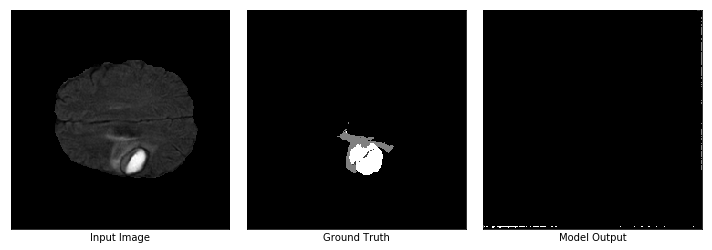

Steps: 2000, Loss:0.46136829257011414
Gradient min:-0.0076342010870575905, max:0.003555117640644312

HGG06_stack.tfrecords


Epochs  2

HGG01_stack.tfrecords


HGG02_stack.tfrecords


HGG03_stack.tfrecords


HGG04_stack.tfrecords


HGG05_stack.tfrecords




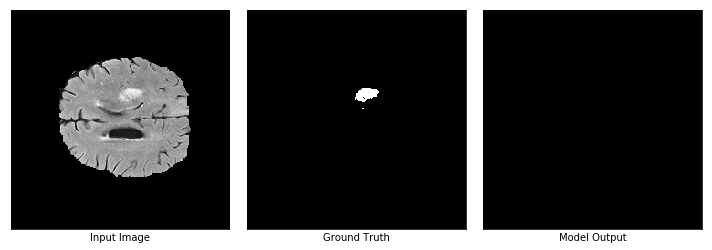

Steps: 2000, Loss:0.1349073052406311
Gradient min:-0.010876045562326908, max:0.018853990361094475

HGG06_stack.tfrecords


Epochs  3

HGG01_stack.tfrecords


HGG02_stack.tfrecords


HGG03_stack.tfrecords


HGG04_stack.tfrecords


HGG05_stack.tfrecords




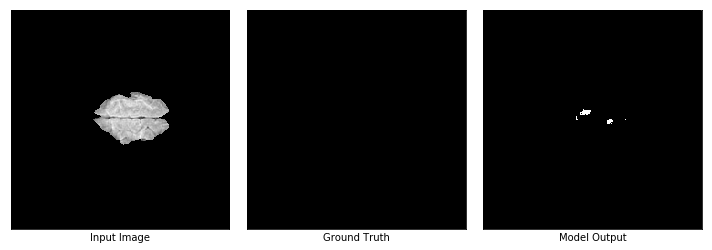

Steps: 2000, Loss:0.053519174456596375
Gradient min:-0.007736479863524437, max:0.014946850016713142

HGG06_stack.tfrecords


Epochs  4

HGG01_stack.tfrecords


HGG02_stack.tfrecords


HGG03_stack.tfrecords


HGG04_stack.tfrecords


HGG05_stack.tfrecords




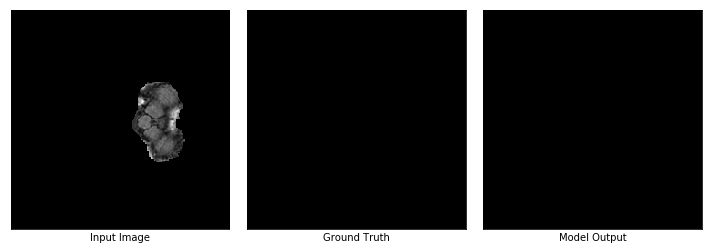

Steps: 2000, Loss:0.029095124453306198
Gradient min:-0.013011467643082142, max:0.010499187745153904

HGG06_stack.tfrecords


Epochs  5

HGG01_stack.tfrecords


HGG02_stack.tfrecords


HGG03_stack.tfrecords


HGG04_stack.tfrecords


HGG05_stack.tfrecords




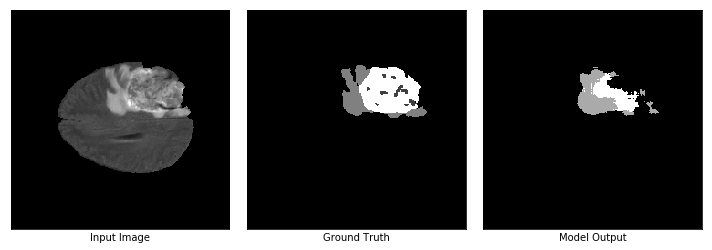

Steps: 2000, Loss:0.021323835477232933
Gradient min:-0.0018284940160810947, max:0.0015775607898831367

HGG06_stack.tfrecords


Epochs  6

HGG01_stack.tfrecords


HGG02_stack.tfrecords


HGG03_stack.tfrecords


HGG04_stack.tfrecords


HGG05_stack.tfrecords




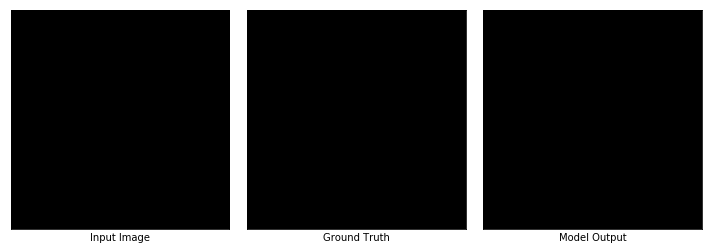

Steps: 2000, Loss:0.024516234174370766
Gradient min:-0.010478072799742222, max:0.016850491985678673

HGG06_stack.tfrecords


Epochs  7

HGG01_stack.tfrecords


HGG02_stack.tfrecords


HGG03_stack.tfrecords


HGG04_stack.tfrecords


HGG05_stack.tfrecords




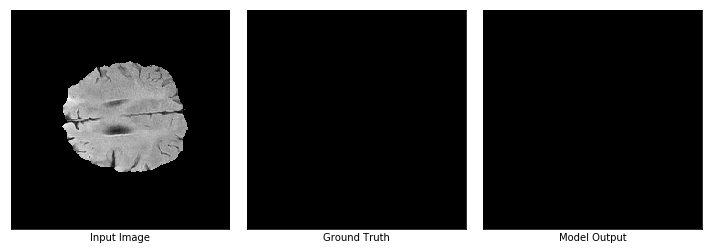

Steps: 2000, Loss:0.016935689374804497
Gradient min:-0.010985109023749828, max:0.0072832559235394

HGG06_stack.tfrecords


Epochs  8

HGG01_stack.tfrecords


HGG02_stack.tfrecords


HGG03_stack.tfrecords


HGG04_stack.tfrecords


HGG05_stack.tfrecords




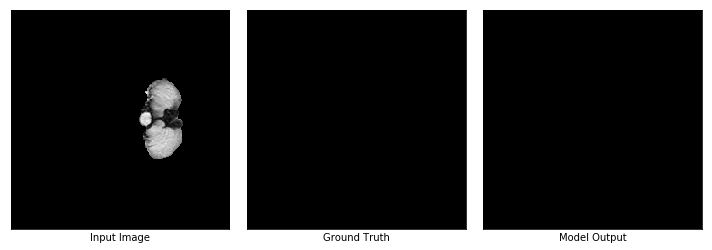

Steps: 2000, Loss:0.016620298847556114
Gradient min:-0.002932072849944234, max:0.003487045643851161

HGG06_stack.tfrecords


Epochs  9

HGG01_stack.tfrecords


HGG02_stack.tfrecords


HGG03_stack.tfrecords


HGG04_stack.tfrecords


HGG05_stack.tfrecords




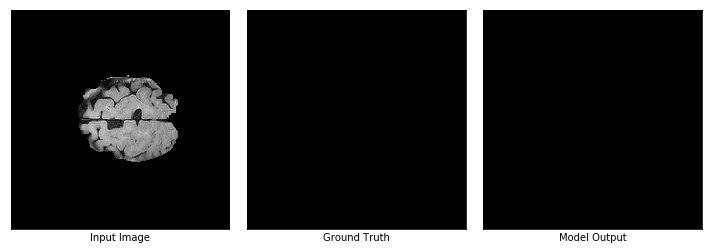

Steps: 2000, Loss:0.019275546073913574
Gradient min:-0.0047459169290959835, max:0.007702141534537077

HGG06_stack.tfrecords


Epochs 10

HGG01_stack.tfrecords


HGG02_stack.tfrecords


HGG03_stack.tfrecords


HGG04_stack.tfrecords


HGG05_stack.tfrecords




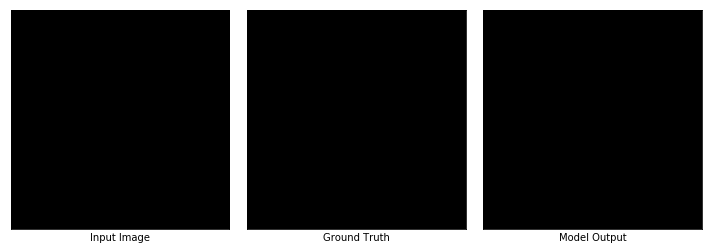

Steps: 2000, Loss:0.033202990889549255
Gradient min:-0.013794202357530594, max:0.010484309867024422

HGG06_stack.tfrecords


Epochs 11

HGG01_stack.tfrecords


HGG02_stack.tfrecords


HGG03_stack.tfrecords


HGG04_stack.tfrecords


HGG05_stack.tfrecords




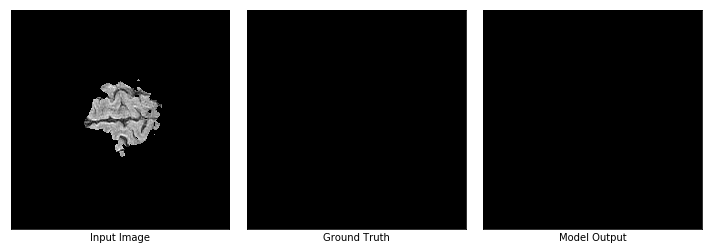

Steps: 2000, Loss:0.011910559609532356
Gradient min:-0.01270125899463892, max:0.008540487848222256

HGG06_stack.tfrecords


Epochs 12

HGG01_stack.tfrecords


HGG02_stack.tfrecords


HGG03_stack.tfrecords


HGG04_stack.tfrecords


HGG05_stack.tfrecords




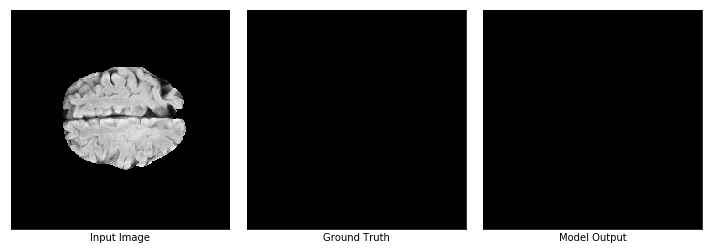

Steps: 2000, Loss:0.014061533845961094
Gradient min:-0.0022297108080238104, max:0.002017790684476495

HGG06_stack.tfrecords


Epochs 13

HGG01_stack.tfrecords


HGG02_stack.tfrecords


HGG03_stack.tfrecords


HGG04_stack.tfrecords


HGG05_stack.tfrecords




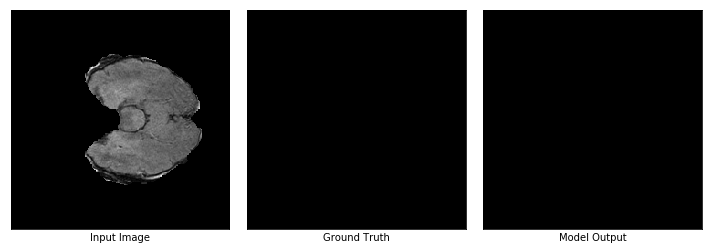

Steps: 2000, Loss:0.028147557750344276
Gradient min:-0.003245551371946931, max:0.0026094643399119377

HGG06_stack.tfrecords


Epochs 14

HGG01_stack.tfrecords


HGG02_stack.tfrecords


HGG03_stack.tfrecords


HGG04_stack.tfrecords


HGG05_stack.tfrecords




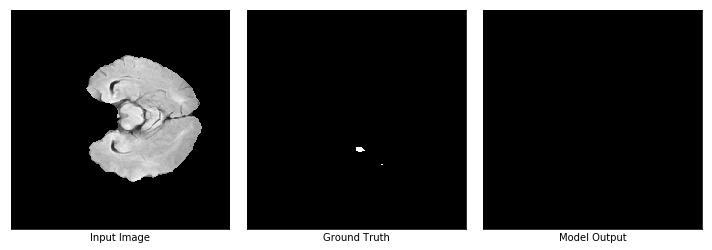

Steps: 2000, Loss:0.012139834463596344
Gradient min:-0.007438939996063709, max:0.0046998863108456135

HGG06_stack.tfrecords


Epochs 15

HGG01_stack.tfrecords


HGG02_stack.tfrecords


HGG03_stack.tfrecords


HGG04_stack.tfrecords


HGG05_stack.tfrecords




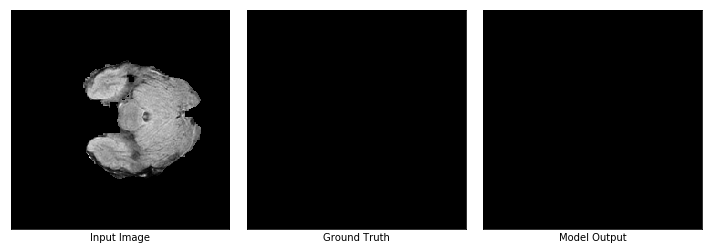

Steps: 2000, Loss:0.014576656743884087
Gradient min:-0.01354090217500925, max:0.009030532091856003

HGG06_stack.tfrecords


Epochs 16

HGG01_stack.tfrecords


HGG02_stack.tfrecords


HGG03_stack.tfrecords


HGG04_stack.tfrecords


HGG05_stack.tfrecords




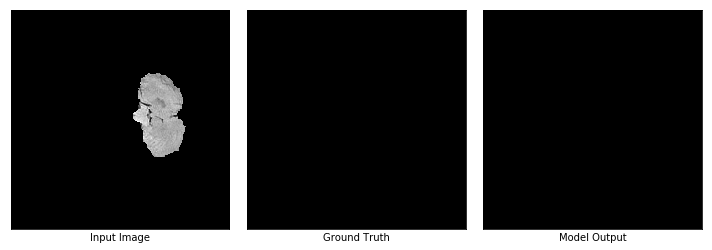

Steps: 2000, Loss:0.018306666985154152
Gradient min:-0.007571891415864229, max:0.00832662358880043

HGG06_stack.tfrecords


Epochs 17

HGG01_stack.tfrecords


HGG02_stack.tfrecords


HGG03_stack.tfrecords


HGG04_stack.tfrecords


HGG05_stack.tfrecords




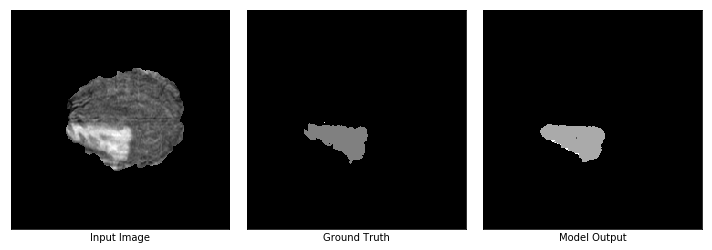

Steps: 2000, Loss:0.019369954243302345
Gradient min:-0.005006947088986635, max:0.003972712438553572

HGG06_stack.tfrecords


Epochs 18

HGG01_stack.tfrecords


HGG02_stack.tfrecords


HGG03_stack.tfrecords


HGG04_stack.tfrecords


HGG05_stack.tfrecords




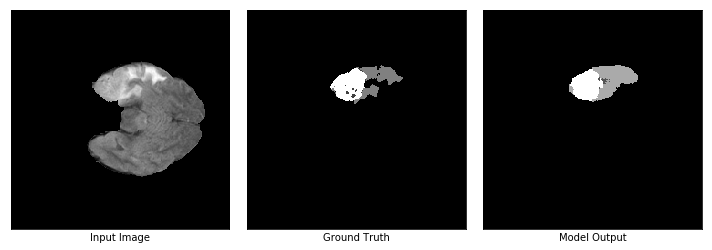

Steps: 2000, Loss:0.021172169595956802
Gradient min:-0.0074498942121863365, max:0.006489942781627178

HGG06_stack.tfrecords


Epochs 19

HGG01_stack.tfrecords


HGG02_stack.tfrecords


HGG03_stack.tfrecords


HGG04_stack.tfrecords


HGG05_stack.tfrecords




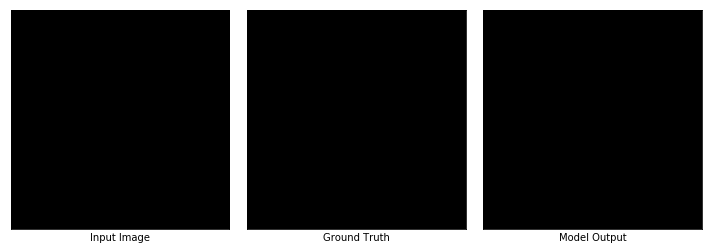

Steps: 2000, Loss:0.006883946713060141
Gradient min:-0.006633225828409195, max:0.004629949573427439

HGG06_stack.tfrecords


Epochs 20

HGG01_stack.tfrecords


HGG02_stack.tfrecords


HGG03_stack.tfrecords


HGG04_stack.tfrecords


HGG05_stack.tfrecords




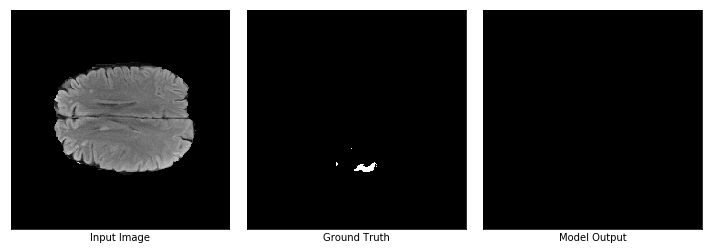

Steps: 2000, Loss:0.017716748639941216
Gradient min:-0.01095243077725172, max:0.0167471282184124

HGG06_stack.tfrecords




In [8]:
epochs = 1
max_epochs = 20
predicted_img = []
groundtruth_img = []
loss_list = []
dice_list = []
while epochs <= max_epochs:
    print("Epochs {:2d}".format(epochs))
    print()
    steps = 1
    for tf_re in sorted(os.listdir(tfrecords_read_dir)):
        print(tf_re)
        print()
        tf_dir = os.path.join(tfrecords_read_dir+tf_re)
        dataset = utils.parse_tfrecord(tf_dir).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
        for imgs in dataset:
            image = imgs[:,:,:,:4]
            #unprocessed label for plotting 
            label = imgs[:,:,:,-1]
            label_plot = label
            #for simplicity label 4 will be converted to 3 for sparse encoding
            label = tf.where(label==4,3,label)
            label = tf.keras.utils.to_categorical(label, num_classes=4)
            img_seg, loss, gradients = train_fn(image, label) #training function 
            img_seg = tf.math.argmax(img_seg,-1) #map from sparse to label
#             dice_score = dice_coef(label, img_seg)
            
#             dice_list.append(dice_score) #append dice score for every every images
            
            #output
            if steps%2000==0:
                input_img = [image[0,:,:,0], label_plot[0], img_seg[0]]
                caption = ['Input Image', 'Ground Truth', 'Model Output']
                plot_comparison(input_img, caption, n_col = 3)
                
                predicted_img.append(img_seg[0])
                groundtruth_img.append(label_plot[0])
                loss_list.append(loss)
#                 dice_coe = dice_coef(label[0], img_seg[0])
#                 print("Steps: {}, Loss:{}, Dice Score:{}".format(steps, loss, dice_coe))
                print("Steps: {}, Loss:{}".format(steps, loss))
                print("Gradient min:{}, max:{}".format(np.min(gradients[0]), np.max(gradients[0])))
            steps+=1
        print()
#         print("Average Dice Coefficient: {}".format(np.mean(np.array(dice_list))))
    epochs+=1 

---

# Model Summary

In [9]:
Unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 240, 240, 64) 2368        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 120, 120, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________